## Leonard Molano  |  Group 6  |  January 29, 2021
### Twitter US Airline Sentiment
A sentiment analysis job about the problems of each major U.S. airline. Twitter data was scraped from February of 2015 and contributors were asked to first classify positive, negative, and neutral tweets, followed by categorizing negative reasons (such as "late flight" or "rude service").

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import numpy as np
import pandas as pd
import re, string, unicodedata
                                      
from bs4 import BeautifulSoup 

import nltk   
from nltk import word_tokenize, sent_tokenize
from nltk.corpus import stopwords, wordnet
from nltk.stem import LancasterStemmer, WordNetLemmatizer   
from nltk.tokenize import WordPunctTokenizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer 

from sklearn.model_selection import train_test_split

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import BaggingRegressor

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

In [3]:
data = pd.read_csv('Tweets.csv')

In [4]:
data.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


In [5]:
data.shape

(14640, 15)

In [6]:
# Drop all other columns except “text” and “airline_sentiment”.
sent = data[['text', 'airline_sentiment']]

In [7]:
sent.head()

,text,airline_sentiment
0,@VirginAmerica What @dhepburn said.,neutral
1,@VirginAmerica plus you've added commercials t...,positive
2,@VirginAmerica I didn't today... Must mean I n...,neutral
3,@VirginAmerica it's really aggressive to blast...,negative
4,@VirginAmerica and it's a really big bad thing...,negative


In [8]:
sent.isnull().sum()

text                 0
airline_sentiment    0
dtype: int64

In [9]:
sent['airline_sentiment'].value_counts()

negative    9178
neutral     3099
positive    2363
Name: airline_sentiment, dtype: int64

## Clean Text for Preprocessing

In [10]:
lemmatizer = WordNetLemmatizer()

handle = '@[A-Za-z0-9]+'
http = 'https?://[^ ]+'
www = 'www.[^ ]+'
combined_p = '|'.join((handle, http, www))

neg_dic = {"isn't":"is not", "aren't":"are not", "wasn't":"was not", "weren't":"were not",
                "wouldn't":"would not", "don't":"do not", "doesn't":"does not","didn't":"did not",
                "can't":"can not","couldn't":"could not","shouldn't":"should not","mightn't":"might not",
                "haven't":"have not","hasn't":"has not","hadn't":"had not","won't":"will not",
                "mustn't":"must not"}

neg = re.compile('\b(' + '|'.join(neg_dic.keys()) + ')\b')
tokenizer = WordPunctTokenizer()

def lemmatize_list(words):
    new_words = []
    for word in words:
      new_words.append(lemmatizer.lemmatize(word, pos='v'))
    return new_words

def clean_text(text):
    stripped = re.sub(combined_p, '', text)
    lower_case = stripped.lower()
    neg_handled = neg.sub(lambda x: neg_dic[x.group()], lower_case)
    letters = re.sub("[^a-zA-Z]", " ", neg_handled)
    words = [x for x in tokenizer.tokenize(letters) if len(x) > 1]
    drop_stopwords = [x for x in words if x not in stopwords.words('english')]
    lem = lemmatize_list(drop_stopwords)
    return (" ".join(lem)).strip()

In [11]:
clean_tweets = []
for tweet in sent.text:
    clean_tweets.append(clean_text(tweet))
sent['clean_text'] = pd.DataFrame(clean_tweets)

In [12]:
sent['text'].head()

0                  @VirginAmerica What @dhepburn said.
1    @VirginAmerica plus you've added commercials t...
2    @VirginAmerica I didn't today... Must mean I n...
3    @VirginAmerica it's really aggressive to blast...
4    @VirginAmerica and it's a really big bad thing...
Name: text, dtype: object

In [13]:
sent['clean_text'].head()

0                                                  say
1                plus add commercials experience tacky
2               today must mean need take another trip
3    really aggressive blast obnoxious entertainmen...
4                                 really big bad thing
Name: clean_text, dtype: object

### Model Pre-Preparation

In [14]:
# One Hot Encode
sent['airline_sentiment'] = sent['airline_sentiment'].replace('neutral', 0)
sent['airline_sentiment'] = sent['airline_sentiment'].replace('negative', 1)
sent['airline_sentiment'] = sent['airline_sentiment'].replace('positive', 2)

In [15]:
tweets = sent['clean_text'].copy()
labels = sent['airline_sentiment'].copy()

### CountVectorizer

In [16]:
vectorizer = CountVectorizer(max_features=1000)  
cvec_data = vectorizer.fit_transform(tweets)
cvec_data = cvec_data.toarray() 

In [17]:
x_train, x_test, y_train, y_test = train_test_split(cvec_data, labels, test_size=0.3, random_state=42)

In [18]:
forest = RandomForestClassifier(n_estimators=10, n_jobs=4)
forest = forest.fit(x_train, y_train)

In [19]:
print(np.mean(cross_val_score(forest, cvec_data, labels, cv=10)))

0.721311475409836


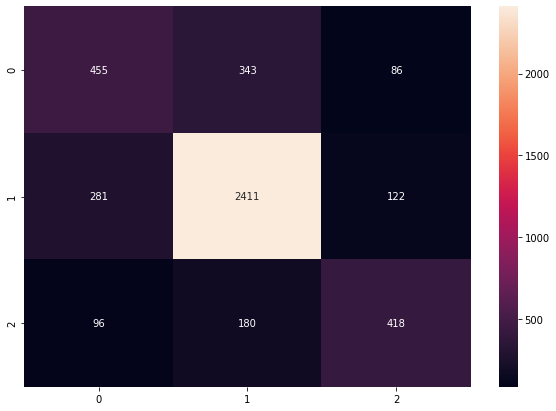

In [20]:
result = forest.predict(x_test)

conf_mat = confusion_matrix(y_test, result)

df_cm = pd.DataFrame(conf_mat, index = [i for i in "012"],
                  columns = [i for i in "012"])
plt.figure(figsize = (10,7))
sns.heatmap(df_cm, annot=True, fmt='g')

### TfidfVectorizer

In [21]:
vectorizer = TfidfVectorizer(max_features=1000)  
tvec_data = vectorizer.fit_transform(tweets)
tvec_data = tvec_data.toarray() 

In [22]:
x_train, x_test, y_train, y_test = train_test_split(tvec_data, labels, test_size=0.3, random_state=42)

In [23]:
forest = RandomForestClassifier(n_estimators=10, n_jobs=4)
forest = forest.fit(x_train, y_train)

In [24]:
print(np.mean(cross_val_score(forest, tvec_data, labels, cv=10)))

0.7327185792349727


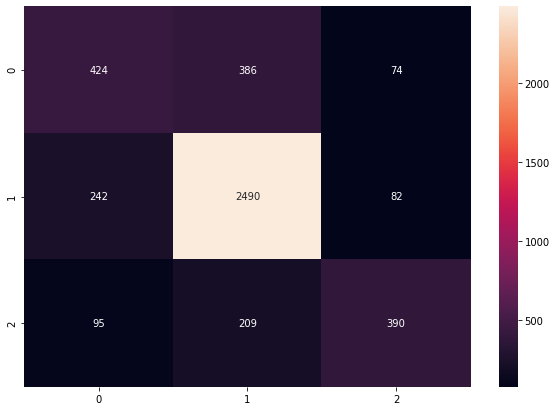

In [25]:
result = forest.predict(x_test)

conf_mat = confusion_matrix(y_test, result)

df_cm = pd.DataFrame(conf_mat, index = [i for i in "012"],
                  columns = [i for i in "012"])
plt.figure(figsize = (10,7))
sns.heatmap(df_cm, annot=True, fmt='g')

## Conclussion

We have created models to analyze tweets about US Airline Sentiment. The way we prepared the data was to 'clean' the text, by removing non-ascii characters, html elements, removing links, user handles, and stop words to further filter the data. After the text was preproced, we used vectorization to convert text into numbers so we can feed the data to our random forest model. Both models scored ~72% accuracy, which is good, but not great. 

In order to improve the model, we could have more carefully selected which words to include or exclude as stop words so we wouldn't miss label ratings. Users also use many abbreviations which could also impact the labeling of our data. User typos could also affect the labeling of the data. We could have also used the removed user handles and further analyze them to see if there was some sort of correlation of specific handles who could impact the score.

In terms of the models, we picked Random Forest since from the baseline models it had the best performance (Linear, Bagging, AdaBoost, and GradientBoost were tried). A Neural network may have delivered a higher quality result, so it will be tried in the future. Finally like with any model, we would need to do feature engineering and hyper parameter tuning to further squeeze performance out of the model .